# Moon Data Classification

In this notebook, you'll be tasked with building and deploying a **custom model** in SageMaker. Specifically, you'll define and train a custom, PyTorch neural network to create a binary classifier for data that is separated into two classes; the data looks like two moon shapes when it is displayed, and is often referred to as **moon data**.

The notebook will be broken down into a few steps:
* Generating the moon data
* Loading it into an S3 bucket
* Defining a PyTorch binary classifier
* Completing a training script
* Training and deploying the custom model
* Evaluating its performance

Being able to train and deploy custom models is a really useful skill to have. Especially in applications that may not be easily solved by traditional algorithms like a LinearLearner.

---

Load in required libraries, below.

In [1]:
# data 
import pandas as pd 
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Generating Moon Data

Below, I have written code to generate some moon data, using sklearn's [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) and [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

I'm specifying the number of data points and a noise parameter to use for generation. Then, displaying the resulting data.

In [2]:
# set data params
np.random.seed(0)
num_pts = 600
noise_val = 0.25

# generate data
# X = 2D points, Y = class labels (0 or 1)
X, Y = make_moons(num_pts, noise=noise_val)

# Split into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=0.25, random_state=1)

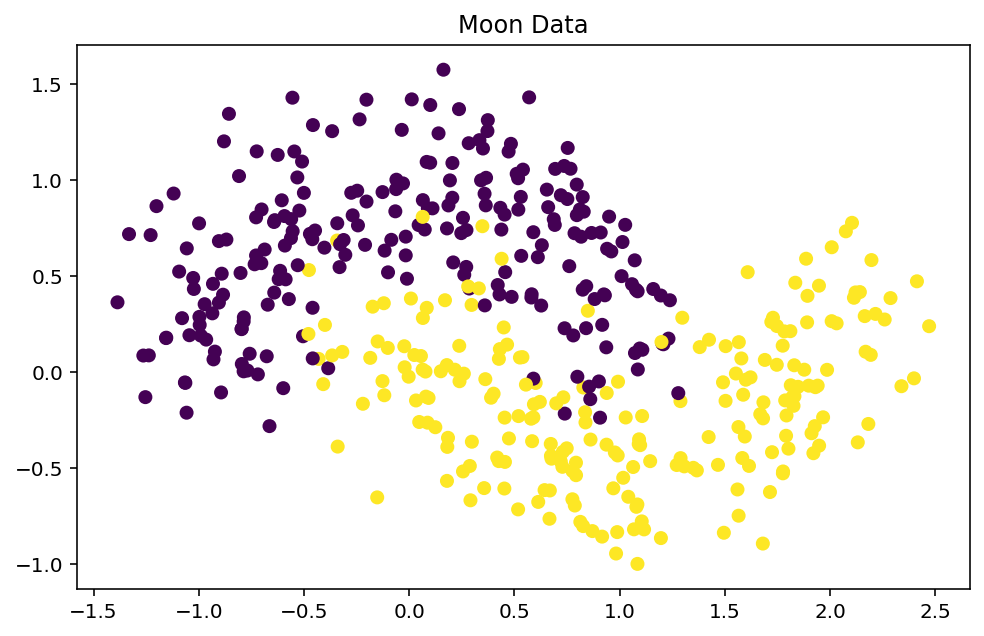

In [3]:
# plot
# points are colored by class, Y_train
# 0 labels = purple, 1 = yellow
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title('Moon Data')
plt.show()

## SageMaker Resources

The below cell stores the SageMaker session and role (for creating estimators and models), and creates a default S3 bucket. After creating this bucket, you can upload any locally stored data to S3.

In [4]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 7.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=8c7a48ee7b9d2ef545f74ed746e72b54537b97fed5350b39d57477f626269b9e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [6]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

### EXERCISE: Create csv files

Define a function that takes in x (features) and y (labels) and saves them to one `.csv` file at the path `data_dir/filename`. SageMaker expects `.csv` files to be in a certain format, according to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html):
> Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable is in the first column.

It may be useful to use pandas to merge your features and labels into one DataFrame and then convert that into a `.csv` file. When you create a `.csv` file, make sure to set `header=False`, and `index=False` so you don't include anything extraneous, like column names, in the `.csv` file.

In [7]:
train_df = pd.DataFrame(Y_train)
train_df.head()

,0
0,0
1,1
2,1
3,0
4,1


In [8]:
import os

def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    path = os.path.join(data_dir, str(filename))
                        
    # your code here
    train_X = pd.DataFrame(x)
    train_y = pd.DataFrame(y)
    train_df = pd.concat([train_y, train_X], axis=1)
    train_data = train_df.to_csv(path, header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
#     print('Path created: '+str(data_dir)+'/'+str(filename))
    print('Path created: ', path)

The next cell runs the above function to create a `train.csv` file in a specified directory.

In [9]:
data_dir = 'data_moon' # the folder we will use for storing data
name = 'train.csv'

# create 'train.csv'
make_csv(X_train, Y_train, name, data_dir)

Path created:  data_moon/train.csv


### Upload Data to S3

Upload locally-stored `train.csv` file to S3 by using `sagemaker_session.upload_data`. This function needs to know: where the data is saved locally, and where to upload in S3 (a bucket and prefix).

In [10]:
# specify where to upload in S3
prefix = 'sagemaker/moon-data'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)


s3://sagemaker-us-west-2-904606187431/sagemaker/moon-data


Check that you've uploaded the data, by printing the contents of the default bucket.

In [11]:
# take a look at the data
data_x = pd.DataFrame(X_train)
data_y = pd.DataFrame(Y_train)
data_df = pd.concat([data_y, data_x], axis=1)
print("Data shape: ", data_df.shape)
data_df.head()

Data shape:  (450, 3)


,0,0,1
0,0,-0.330690,0.546602
1,1,0.732786,-0.130526
2,1,0.170382,0.374491
3,0,-0.209513,0.662376
4,1,0.453906,-0.236074


---
# Modeling

Now that you've uploaded your training data, it's time to define and train a model!

In this notebook, you'll define and train a **custom PyTorch model**; a neural network that performs binary classification. 

### EXERCISE: Define a model in  `model.py`

To implement a custom classifier, the first thing you'll do is define a neural network. You've been give some starting code in the directory `source`, where you can find the file, `model.py`. You'll need to complete the class `SimpleNet`; specifying the layers of the neural network and its feedforward behavior. It may be helpful to review the [code for a 3-layer MLP](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb).

This model should be designed to: 
* Accept a number of `input_dim` features
* Create some linear, hidden layers of a desired size
* Return **a single output value** that indicates the class score

The returned output value should be a [sigmoid-activated](https://pytorch.org/docs/stable/nn.html#sigmoid) class score; a value between 0-1 that can be rounded to get a predicted, class label.

Below, you can use !pygmentize to display the code in the `model.py` file. Read through the code; all of your tasks are marked with TODO comments. You should navigate to the file, and complete the tasks to define a `SimpleNet`.

In [48]:
# !pygmentize source/model.py

In [12]:
from source.model import SimpleNet

In [13]:
model = SimpleNet(512, 256, 2)
print(model)

SimpleNet(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Training Script

To implement a custom classifier, you'll also need to complete a `train.py` script. You can find this in the `source` directory.

A typical training script:

* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model
* Finally, saves the model so that it can be hosted/deployed, later

### EXERCISE: Complete the `train.py` script

Much of the training script code is provided for you. Almost all of your work will be done in the if __name__ == '__main__': section. To complete the `train.py` file, you will:

* Define any additional model training hyperparameters using `parser.add_argument`
* Define a model in the if __name__ == '__main__': section
* Train the model in that same section

Below, you can use !pygmentize to display an existing train.py file. Read through the code; all of your tasks are marked with TODO comments.

In [47]:
# !pygmentize source/train.py

### EXERCISE: Create a PyTorch Estimator

You've had some practice instantiating built-in models in SageMaker. All estimators require some constructor arguments to be passed in. When a custom model is constructed in SageMaker, an **entry point** must be specified. The entry_point is the training script that will be executed when the model is trained; the `train.py` function you specified above! 

See if you can complete this task, instantiating a PyTorch estimator, using only the [PyTorch estimator documentation](https://sagemaker.readthedocs.io/en/stable/sagemaker.pytorch.html) as a resource. It is suggested that you use the **latest version** of PyTorch as the optional `framework_version` parameter.

#### Instance Types

It is suggested that you use instances that are available in the free tier of usage: `'ml.c4.xlarge'` for training and `'ml.t2.medium'` for deployment.

In [19]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
output_path = 's3://{}/{}/'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.0',
                    output_path=output_path,
                    train_instance_count=1, 
                    train_instance_type='ml.c4.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 2, # num features
                        'hidden_dim': 25,
                        'output_dim': 1,
                        'epochs': 90
                    })


## Train the Estimator

After instantiating your estimator, train it with a call to `.fit()`. The `train.py` file explicitly loads in `.csv` data, so you do not need to convert the input data to any other format.

In [20]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data}) # pass in a dictionary specifying the train channel

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-07-19 22:47:54 Starting - Starting the training job...
2021-07-19 22:47:56 Starting - Launching requested ML instances......
2021-07-19 22:49:08 Starting - Preparing the instances for training.........
2021-07-19 22:50:41 Downloading - Downloading input data
2021-07-19 22:50:41 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-19 22:51:02,280 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-19 22:51:02,282 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-19 22:51:02,295 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-19 22:51:02,296 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-19 22:51:02,662 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-07-19 22:51:02,

## Create a Trained Model

PyTorch models do not automatically come with `.predict()` functions attached (as many Scikit-learn models do, for example) and you may have noticed that you've been give a `predict.py` file. This file is responsible for loading a trained model and applying it to passed in, numpy data. When you created a PyTorch estimator, you specified where the training script, `train.py` was located. 

> How can we tell a PyTorch model where the `predict.py` file is?

Before you can deploy this custom PyTorch model, you have to take one more step: creating a `PyTorchModel`. In earlier exercises you could see that a call to `.deploy()` created both a **model** and an **endpoint**, but for PyTorch models, these steps have to be separate.

### EXERCISE: Instantiate a `PyTorchModel`

You can create a `PyTorchModel` (different that a PyTorch estimator) from your trained, estimator attributes. This model is responsible for knowing how to execute a specific `predict.py` script. And this model is what you'll deploy to create an endpoint.

#### Model Parameters

To instantiate a `PyTorchModel`, ([documentation, here](https://sagemaker.readthedocs.io/en/stable/sagemaker.pytorch.html#sagemaker.pytorch.model.PyTorchModel)) you pass in the same arguments as your PyTorch estimator, with a few additions/modifications:
* **model_data**: The trained `model.tar.gz` file created by your estimator, which can be accessed as `estimator.model_data`.
* **entry_point**: This time, this is the path to the Python script SageMaker runs for **prediction** rather than training, `predict.py`.


In [21]:
%%time
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role=role,
                     framework_version='1.0', # get most current version
                     entry_point='predict.py',
                     source_dir='source')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 54.8 ms


### EXERCISE: Deploy the trained model

Deploy your model to create a predictor. We'll use this to make predictions on our test data and evaluate the model.

In [23]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!CPU times: user 489 ms, sys: 33.3 ms, total: 522 ms
Wall time: 7min 32s


---
## Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to the test data.

The provided function below, takes in a deployed predictor, some test features and labels, and returns a dictionary of metrics; calculating false negatives and positives as well as recall, precision, and accuracy.

In [24]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}



### Test Results

The cell below runs the `evaluate` function. 

The code assumes that you have a defined `predictor` and `X_test` and `Y_test` from previously-run cells.

In [25]:
# get metrics for custom predictor
metrics = evaluate(predictor, X_test, Y_test, True)

predictions  0.0  1.0
actuals              
0             53   18
1             10   69

Recall:     0.873
Precision:  0.793
Accuracy:   0.813



## Delete the Endpoint

Finally, I've add a convenience function to delete prediction endpoints after we're done with them. And if you're done evaluating the model, you should delete your model endpoint!

In [26]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [27]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted sagemaker-pytorch-2021-07-19-22-56-28-066


## Final Cleanup!

* Double check that you have deleted all your endpoints.
* I'd also suggest manually deleting your S3 bucket, models, and endpoint configurations directly from your AWS console.

You can find thorough cleanup instructions, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

---
# Conclusion

In this notebook, you saw how to train and deploy a custom, PyTorch model in SageMaker. SageMaker has many built-in models that are useful for common clustering and classification tasks, but it is useful to know how to create custom, deep learning models that are flexible enough to learn from a variety of data.